In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import mglearn
from tqdm import tqdm, trange
import numpy as np

50. データの入手・整形  
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

    1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
    2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
    3. 抽出された事例をランダムに並び替える．
    4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

    学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．


In [36]:
df = pd.read_csv('./NewsAggregatorDataset/newsCorpora.csv', sep='\t', header=None, names=['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP'])
extracted = df[df['PUBLISHER'].isin(['Reuters','Huffington Post','Businessweek','Contactmusic.com','Daily Mail'])]
extracted = extracted[['CATEGORY','TITLE']]

train, val_test = train_test_split(extracted, test_size=0.2, shuffle=True, random_state=1, stratify=extracted["CATEGORY"])

valid, test = train_test_split(val_test, test_size=0.5, shuffle=True, random_state=1, stratify=val_test["CATEGORY"])

In [37]:
train.to_csv('train.txt', sep="\t", index=None)
valid.to_csv('valid.txt', sep="\t", index=None)
test.to_csv('test.txt', sep="\t", index=None)

In [46]:
df['CATEGORY'].value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

51.  特徴量抽出  
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [48]:
def preprocess(text) -> str:
    import texthero as hero
    clean_text = hero.clean(text, pipeline=[
        hero.preprocessing.fillna, 
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits, 
        hero.preprocessing.remove_punctuation, 
        hero.preprocessing.remove_diacritics, 
        hero.preprocessing.remove_stopwords
    ])
    return clean_text

In [63]:
vectorizer = TfidfVectorizer()
train_v = vectorizer.fit_transform(preprocess(train['TITLE']))
valid_v = vectorizer.transform(preprocess(valid['TITLE']))
test_v = vectorizer.transform(preprocess(test['TITLE']))

train_feature = pd.DataFrame(train_v.toarray(), columns=vectorizer.get_feature_names_out())
valid_feature = pd.DataFrame(valid_v.toarray(), columns=vectorizer.get_feature_names_out())
test_feature = pd.DataFrame(test_v.toarray(), columns=vectorizer.get_feature_names_out())

309673    CORRECTED-UPDATE 7-Brent crude falls again as ...
131681    CORRECTED-Retailer Michaels Stores confirms pa...
14583     Britney Spears hits her local supermarket dres...
176257    Orders Propel US Service Industries as Sales I...
401048    COLUMN-Fed to widen Main St/Wall St gap: James...
                                ...                        
221841    David Cronenberg's "Maps to the Stars" At Cann...
45752     Kim Kardashian Stalker Taken Into Custody Afte...
57096     Euro Drops to 3-Week Low Against Pound on Outl...
175007    Fashion Designers Dolce, Gabbana Lose Appeal o...
333880    Corn Falls on Bets US Inventories to Rise; Whe...
Name: TITLE, Length: 10672, dtype: object
242779    'I'm proud of that': Duck Dynasty's Jase Rober...
397533    California man who went on run after refusing ...
280125    Chris Christie Busts A Move On The 'Tonight Show'
376475    UPDATE 3-BOJ says inflation to stay above 1 pc...
376364    A Brief, Delicious History Of The Great Cupcak..

In [64]:
train_feature.to_csv('train.feature.txt', sep="\t", index=None)
valid_feature.to_csv('valid.feature.txt', sep="\t", index=None)
test_feature.to_csv('test.feature.txt', sep="\t", index=None)

52.  学習  
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [67]:
lr = LogisticRegression(random_state=1, max_iter=10000)
lr.fit(train_feature, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=1)

53. 予測  
    52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．
54.  正解率の計測  
    52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．
55. 混同行列の作成  
    52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [74]:
def prediction(model, x, y):
    pred = model.predict(x)
    print('prediction:', pred)
    print('confusion matrix:\n',confusion_matrix(y, pred))
    print('accuracy:',accuracy_score(y, pred))

    return pred

In [75]:
train_pred = prediction(lr, train_feature, train['CATEGORY'])

prediction: ['b' 'b' 'e' ... 'b' 'e' 'b']
confusion matrix:
 [[4445   28    2   27]
 [  19 4201    0    3]
 [  80  122  523    3]
 [ 125  110    3  981]]
accuracy: 0.9510869565217391


In [77]:
valid_pred = prediction(lr, valid_feature, valid['CATEGORY'])

prediction: ['e' 'e' 'e' ... 'b' 't' 'b']
confusion matrix:
 [[536  21   0   6]
 [ 10 517   0   1]
 [ 16  24  50   1]
 [ 41  29   0  82]]
accuracy: 0.8883058470764618


In [76]:
test_pred = prediction(lr, test_feature, test['CATEGORY'])

prediction: ['b' 'b' 'e' ... 'e' 'b' 'e']
confusion matrix:
 [[531  12   3  16]
 [  5 521   1   1]
 [ 18  31  40   2]
 [ 42  25   2  84]]
accuracy: 0.881559220389805


56. 適合率，再現率，F1スコアの計測  
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [ ]:
def prec_recall_f1(tr, pred, ave='macro'):
    print('precision score:',precision_score(tr, pred, average=ave))
    print('recall score:',recall_score(tr, pred, average=ave))
    print('f1 score:',f1_score(tr, pred, average=ave))

In [78]:
category = {0:'b', 1:'e', 2:'m', 3:'t'}
tprec = 0
conmat = confusion_matrix(test['CATEGORY'], test_pred)

for c in category.keys():
    print('category: ',category[c])
    prec = conmat[c,c] / sum(conmat[:,c]) * 100
    recall = conmat[c,c] / sum(conmat[c,:]) * 100
    
    print('precision score = ', prec, "%")
    print('recall score = ', recall, "%")
    print('f1 score = ', (2*prec*recall)/(recall+prec), "%\n")

category:  b
precision score =  89.09395973154362 %
recall score =  94.48398576512456 %
f1 score =  91.70984455958549 %

category:  e
precision score =  88.45500848896435 %
recall score =  98.67424242424242 %
f1 score =  93.28558639212177 %

category:  m
precision score =  86.95652173913044 %
recall score =  43.956043956043956 %
f1 score =  58.3941605839416 %

category:  t
precision score =  81.55339805825243 %
recall score =  54.90196078431373 %
f1 score =  65.625 %



In [79]:
print('\t=== macro ===')
print('precision score:',precision_score(test['CATEGORY'], test_pred, average='macro'))
print('recall score:',recall_score(test['CATEGORY'], test_pred, average='macro'))
print('f1 score:',f1_score(test['CATEGORY'], test_pred, average='macro'))

print('\t=== micro ===')
print('precision score:',precision_score(test['CATEGORY'], test_pred, average='micro'))
print('recall score:',recall_score(test['CATEGORY'], test_pred, average='micro'))
print('f1 score:',f1_score(test['CATEGORY'], test_pred, average='micro'))

	=== macro ===
precision score: 0.8651472200447271
recall score: 0.7300405823243117
f1 score: 0.7725364788391222
	=== micro ===
precision score: 0.881559220389805
recall score: 0.881559220389805
f1 score: 0.8815592203898052


57. 特徴量の重みの確認  
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

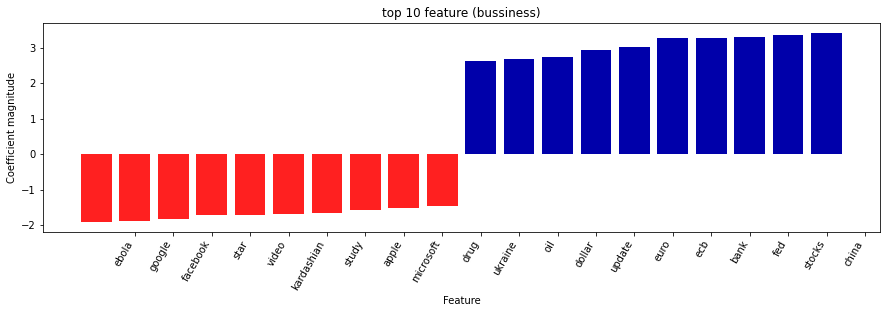

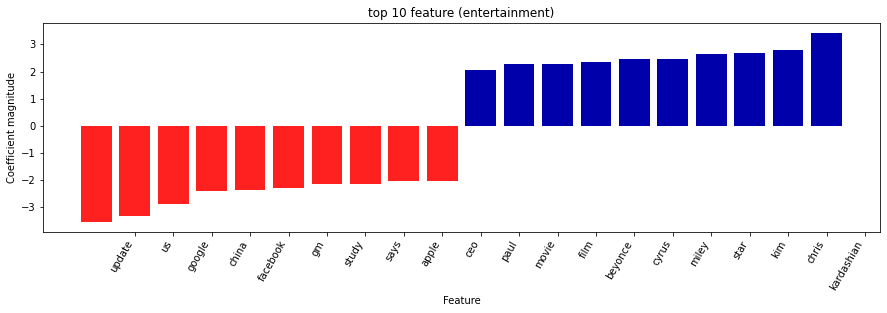

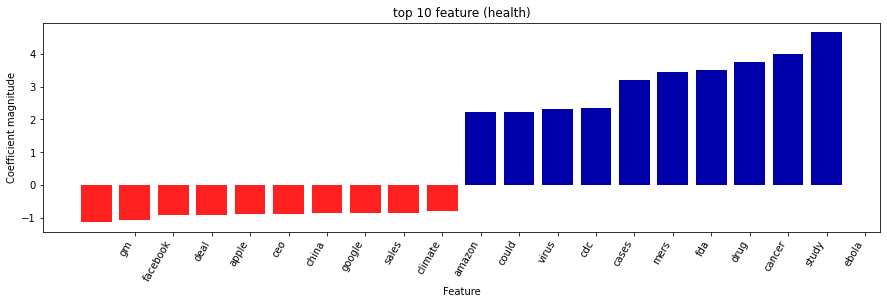

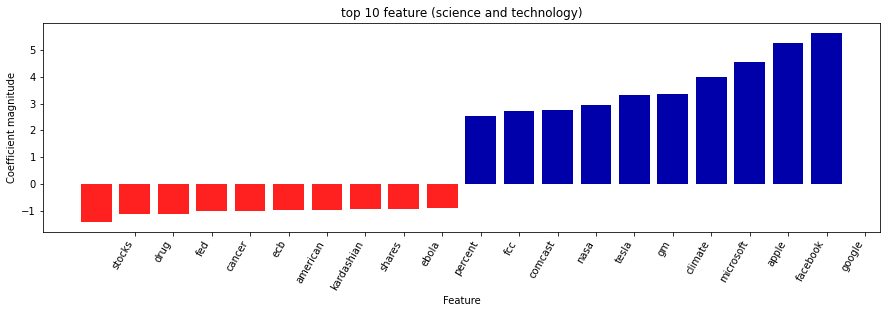

In [80]:
columns = train_feature.columns.values
categoly = ['bussiness', 'entertainment', 'health', 'science and technology']
for i in range(4):
    mglearn.tools.visualize_coefficients(lr.coef_[i,:], columns, n_top_features=10)
    plt.title("top 10 feature ("+categoly[i]+")")
    plt.show()

58. 正則化パラメータの変更  
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

100%|██████████| 11/11 [20:23<00:00, 111.21s/it]


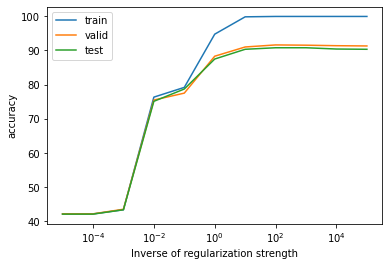

In [60]:
train_result = []
valid_result = []
test_result = []

param = np.logspace(-5, 5, 11, base=10)
for x in tqdm(param):
    lr = LogisticRegression(C=x, random_state=1, max_iter=10000)
    lr.fit(train_feature, train['CATEGORY'])

    # train
    train_pred = lr.predict(train_feature)
    train_result.append(100*accuracy_score(train['CATEGORY'], train_pred))

    # valid
    valid_pred = lr.predict(valid_feature)
    valid_result.append(100*accuracy_score(valid['CATEGORY'], valid_pred))

    # test
    test_pred = lr.predict(test_feature)
    test_result.append(100*accuracy_score(test['CATEGORY'], test_pred))

plt.plot(param, train_result, label = "train")
plt.plot(param, valid_result, label = "valid")
plt.plot(param, test_result, label = "test")
plt.xscale('log')
plt.xlabel("Inverse of regularization strength")
plt.ylabel("accuracy")
plt.legend()

59. ハイパーパラメータの探索  
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [61]:
clst = np.linspace(0.5, 5.0, 10)
wlst = ['balanced', None]
slst = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

best = {'accuracy':0.0, 'c':None, 'w':None, 's':None}

for i in trange(10, desc='c loop'):
    c = clst[i]
    for j in trange(2, desc='w loop', leave=False):
        w = wlst[j]
        for k in trange(5, desc='s loop', leave=False):
            s = slst[k]
            lr = LogisticRegression(C=c, class_weight=w, solver=s, random_state=1, max_iter=10000)
            lr.fit(train_feature, train['CATEGORY'])

            pred = lr.predict(valid_feature)
            acc = 100*accuracy_score(valid['CATEGORY'], pred)
            if best['accuracy'] < acc:
                best['accuracy'] = acc
                best['c'] = c
                best['w'] = w
                best['s'] = s

lr = LogisticRegression(C=best['c'], class_weight=best['w'], solver=best['s'], random_state=1, max_iter=10000)
lr.fit(train_feature, train['CATEGORY'])

pred = lr.predict(test_feature)
acc = 100*accuracy_score(test['CATEGORY'], pred)

print("c:{0}\nw:{1}\ns:{2}\naccuracy:{3}%".format(best['c'],best['w'],best['s'],acc))

c loop:   0%|          | 0/10 [00:00<?, ?it/s]













c loop:  10%|█         | 1/10 [42:22<6:21:20, 2542.27s/it]



